In [1]:
#####################################################################
# This file is for miscellaneous tasks. It's debatable if it should #
# have been committed to Github, but there's an error in removing   #
# it so we have to live with it now, I guess.                       #
#####################################################################
from __future__ import print_function, division
import os
import sys

"""Open MP and MKL should speed up the time required to run these simulations!"""
# threads = sys.argv[1]
threads = 1
os.environ['NUMEXPR_MAX_THREADS'] = '{}'.format(threads)
os.environ['NUMEXPR_NUM_THREADS'] = '{}'.format(threads)
os.environ['OMP_NUM_THREADS'] = '{}'.format(threads)
os.environ['MKL_NUM_THREADS'] = '{}'.format(threads)

from quspin.operators import hamiltonian, exp_op, quantum_operator  # operators
from quspin.basis import spinful_fermion_basis_1d  # Hilbert space basis
from quspin.tools.measurements import obs_vs_time  # calculating dynamics
from quspin.tools.evolution import evolve  # evolving system
import numpy as np  # general math functions
from time import time  # tool for calculating computation time
from tqdm import tqdm
import matplotlib.pyplot as plt  # plotting library
from scipy.signal import find_peaks, hilbert, windows
from scipy.signal.windows import blackman
from scipy.integrate import simps
from scipy import fftpack
from scipy.interpolate import UnivariateSpline
from quspin.tools.measurements import project_op
from tools import HubbardModel as fhmodel, InitializeArchive
import psutil

In [2]:
########################################################################################################################
# Are you loading multiple files? If so you need to implement a way to do that here
########################################################################################################################

results_lib = dict()

In [7]:
########################################################################################################################
# Declare Parameters of system to be loaded
########################################################################################################################

"""Parameters for a target or reference field"""
# Hubbard model
L = 10           # System size
t0 = 0.52        # hopping strength
U = 0.00 * t0    # interaction strength
F0 = 10         # Field amplitude MV/cm
U_list = np.array([0.0])
params = dict()

for _ in U_list:
    load_params = dict(
        angular_frequency=32.9,    # Field angular frequency THz
        field_amplitude=F0,        # Field amplitude MV/cm
        lattice_constant=4,        # Lattice constant Angstroms
        nx=L,                      # system size
        n_up=L // 2 + L % 2,       # number of fermions with spin up
        n_down=L // 2,             # number of fermions with spin down
        hopping=t0,                # hopping strength
        interaction=_*0.52,             # interaction strength
        chem_potential=0,
        cycles=10,                 # time in cycles of field frequency
        n_steps=10000,              # Number of steps for time resolution
        ny=0,                      # 1D simulations do not use y-axis
        pbc=True,
        soc=0,                     # No spin orbit coupling
        gamma=0,
        tracking=True,             # Are you loading a field for tracking
        int_track=1.0*t0,               # If so, you need to list the U for
        scf=False,
    )

    params[_] = load = fhmodel(**load_params)
    start = 0.0
    times, dt = np.linspace(start, load.stop, num=load.n_steps, endpoint=True, retstep=True)


Angular frequency= 0.262
Frequency= 0.042
Lattice constant= 0.144
Field Amplitude= 5.325


In [8]:
########################################################################################################################
# Load the relevant file
########################################################################################################################
# Reference: 0 for Targets, 1 for Tracking, 2 for superoscillations, 3 for importing anything else
sim_type_to_be_loaded = 1

# Target the filed to be loaded
loader = InitializeArchive(directory_number=sim_type_to_be_loaded).get_dir()
load_path = loader['data path']
load_tag = loader['tag']

# If pasting a direct location, use this
#loadfile = './Data/BestFit_SCF/SCFparams_10sites-0,049TrackedTo0,000U-0,52t0-4,5F0-4TrackedTo4a-10cycles-4000steps_N133pulses.npz'
# Otherwise have the class file find it for you

for _ in params:
    filename = load_tag + params[_].tag
    loadpath = load_path + filename + '.npz'
    print('Loaded file: {}'.format(loadpath))
    loadfile = np.load(loadpath)
    results_lib[filename] = loadfile
    print('Result stored in library under tag: {}'.format(filename))


Loaded file: ./Data/TrackingResults/Trackedparams_10sites-0,000U-0,52t0-10F0-4a-10cycles-10000stepsTrackedToSystem-0,520U.npz
Result stored in library under tag: Trackedparams_10sites-0,000U-0,52t0-10F0-4a-10cycles-10000stepsTrackedToSystem-0,520U


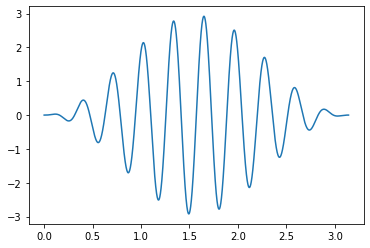

In [9]:
####################################################################################
#
# Verify the maximum frequency by comparing it to the frequency of the initial field
#
####################################################################################
def tfl_pulse(current_time):
    """
    Defines the transform limited pulse for an individual time step
    :param current_time: Current time
    :return: transform limited pulse (current time)
    """
    return (load.a * load.F0 / load.omega) * (np.sin(load.omega * current_time / (2. * load.cycles)) ** 2.) * np.sin(
        load.omega * current_time)
pi_times = np.linspace(0.0, np.pi, load.n_steps)
component_field = tfl_pulse(times)
plt.plot(pi_times, component_field)
plt.show()


Angular frequency= 0.262
Frequency= 0.042
Lattice constant= 0.144
Field Amplitude= 5.325
Loaded file: ./Data/TargetsForTracking/TGTparams_10sites-0,000U-0,52t0-10F0-4a-10cycles-10000steps.npz


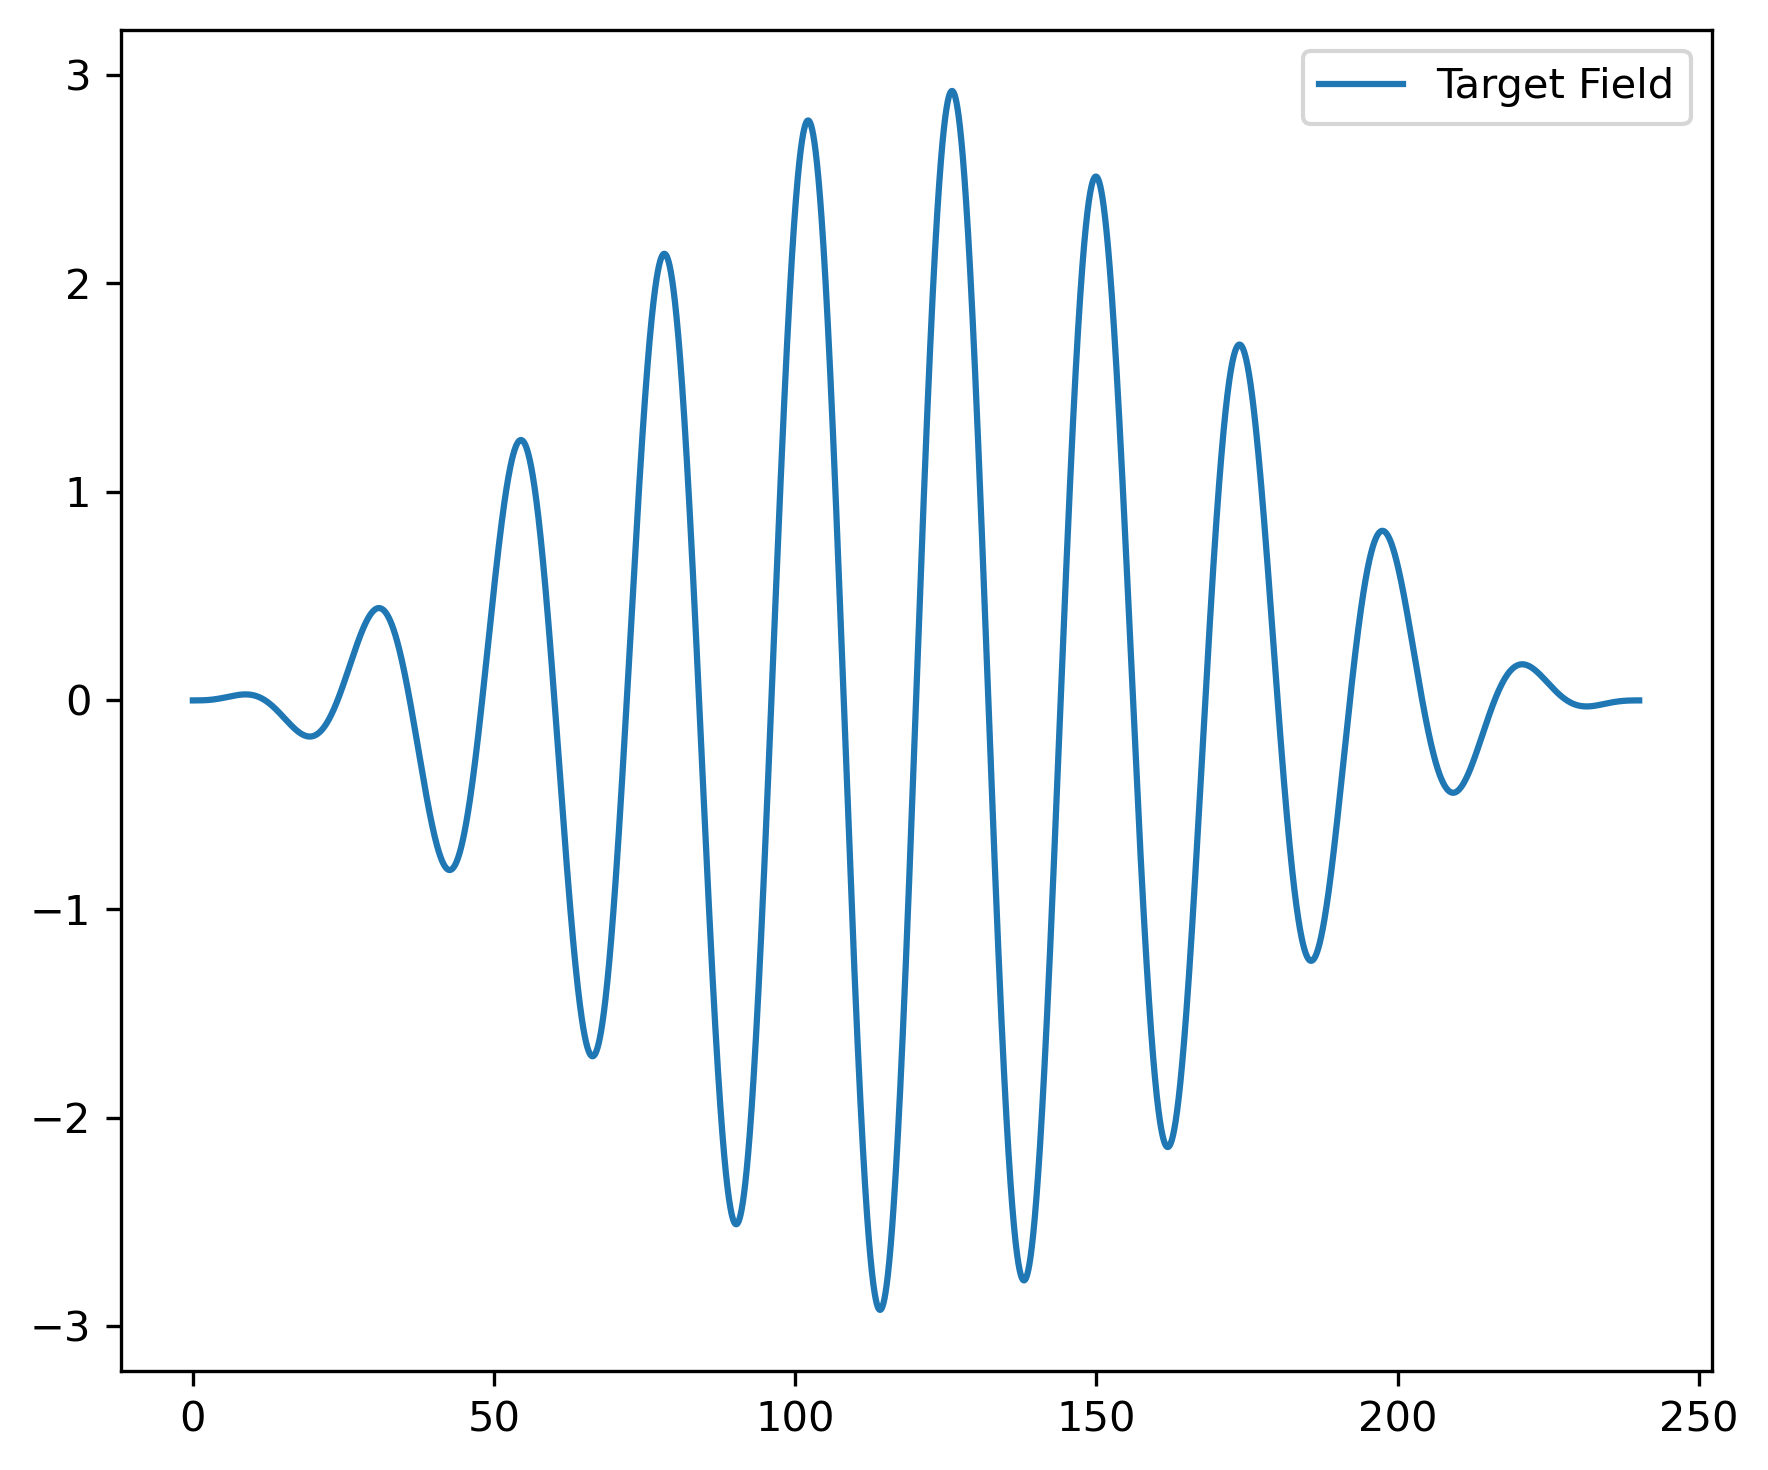

In [10]:
####################################################################################
#
# Get the original target field
#
####################################################################################

tgt_params = dict(
    angular_frequency=32.9,    # Field angular frequency THz
    field_amplitude=F0,        # Field amplitude MV/cm
    lattice_constant=4,        # Lattice constant Angstroms
    nx=L,                      # system size
    n_up=L // 2 + L % 2,       # number of fermions with spin up
    n_down=L // 2,             # number of fermions with spin down
    hopping=t0,                # hopping strength
    interaction=0.0*0.52,             # interaction strength
    chem_potential=0,
    cycles=10,                 # time in cycles of field frequency
    n_steps=10000,              # Number of steps for time resolution
    ny=0,                      # 1D simulations do not use y-axis
    pbc=True,
    soc=0,                     # No spin orbit coupling
    gamma=0,
    tracking=False,             # Are you loading a field for tracking
)

tgt = fhmodel(**tgt_params)
tgt_start = 0.0
tgt_times, tgt_dt = np.linspace(tgt_start, tgt.stop, num=tgt.n_steps, endpoint=True, retstep=True)


# Target the filed to be loaded
tgt_loader = InitializeArchive(directory_number=0).get_dir()
tgt_path = tgt_loader['data path']
tgt_tag = tgt_loader['tag']

tgt_name = tgt_tag + tgt.tag
tgt_loadpath = tgt_path + tgt_name + '.npz'
print('Loaded file: {}'.format(tgt_loadpath))
tgt_file = np.load(tgt_loadpath)

# Interpolate the field such that it matches the times of comparrison plots
loaded_field = tgt_file['phi']
tgt_phi = UnivariateSpline(tgt_times, loaded_field, k=3, s=0)

plt.figure(figsize=(6,5), dpi=300)
plt.plot(times, tgt_phi(times), label='Target Field')
plt.legend()
plt.tight_layout()
plt.show()

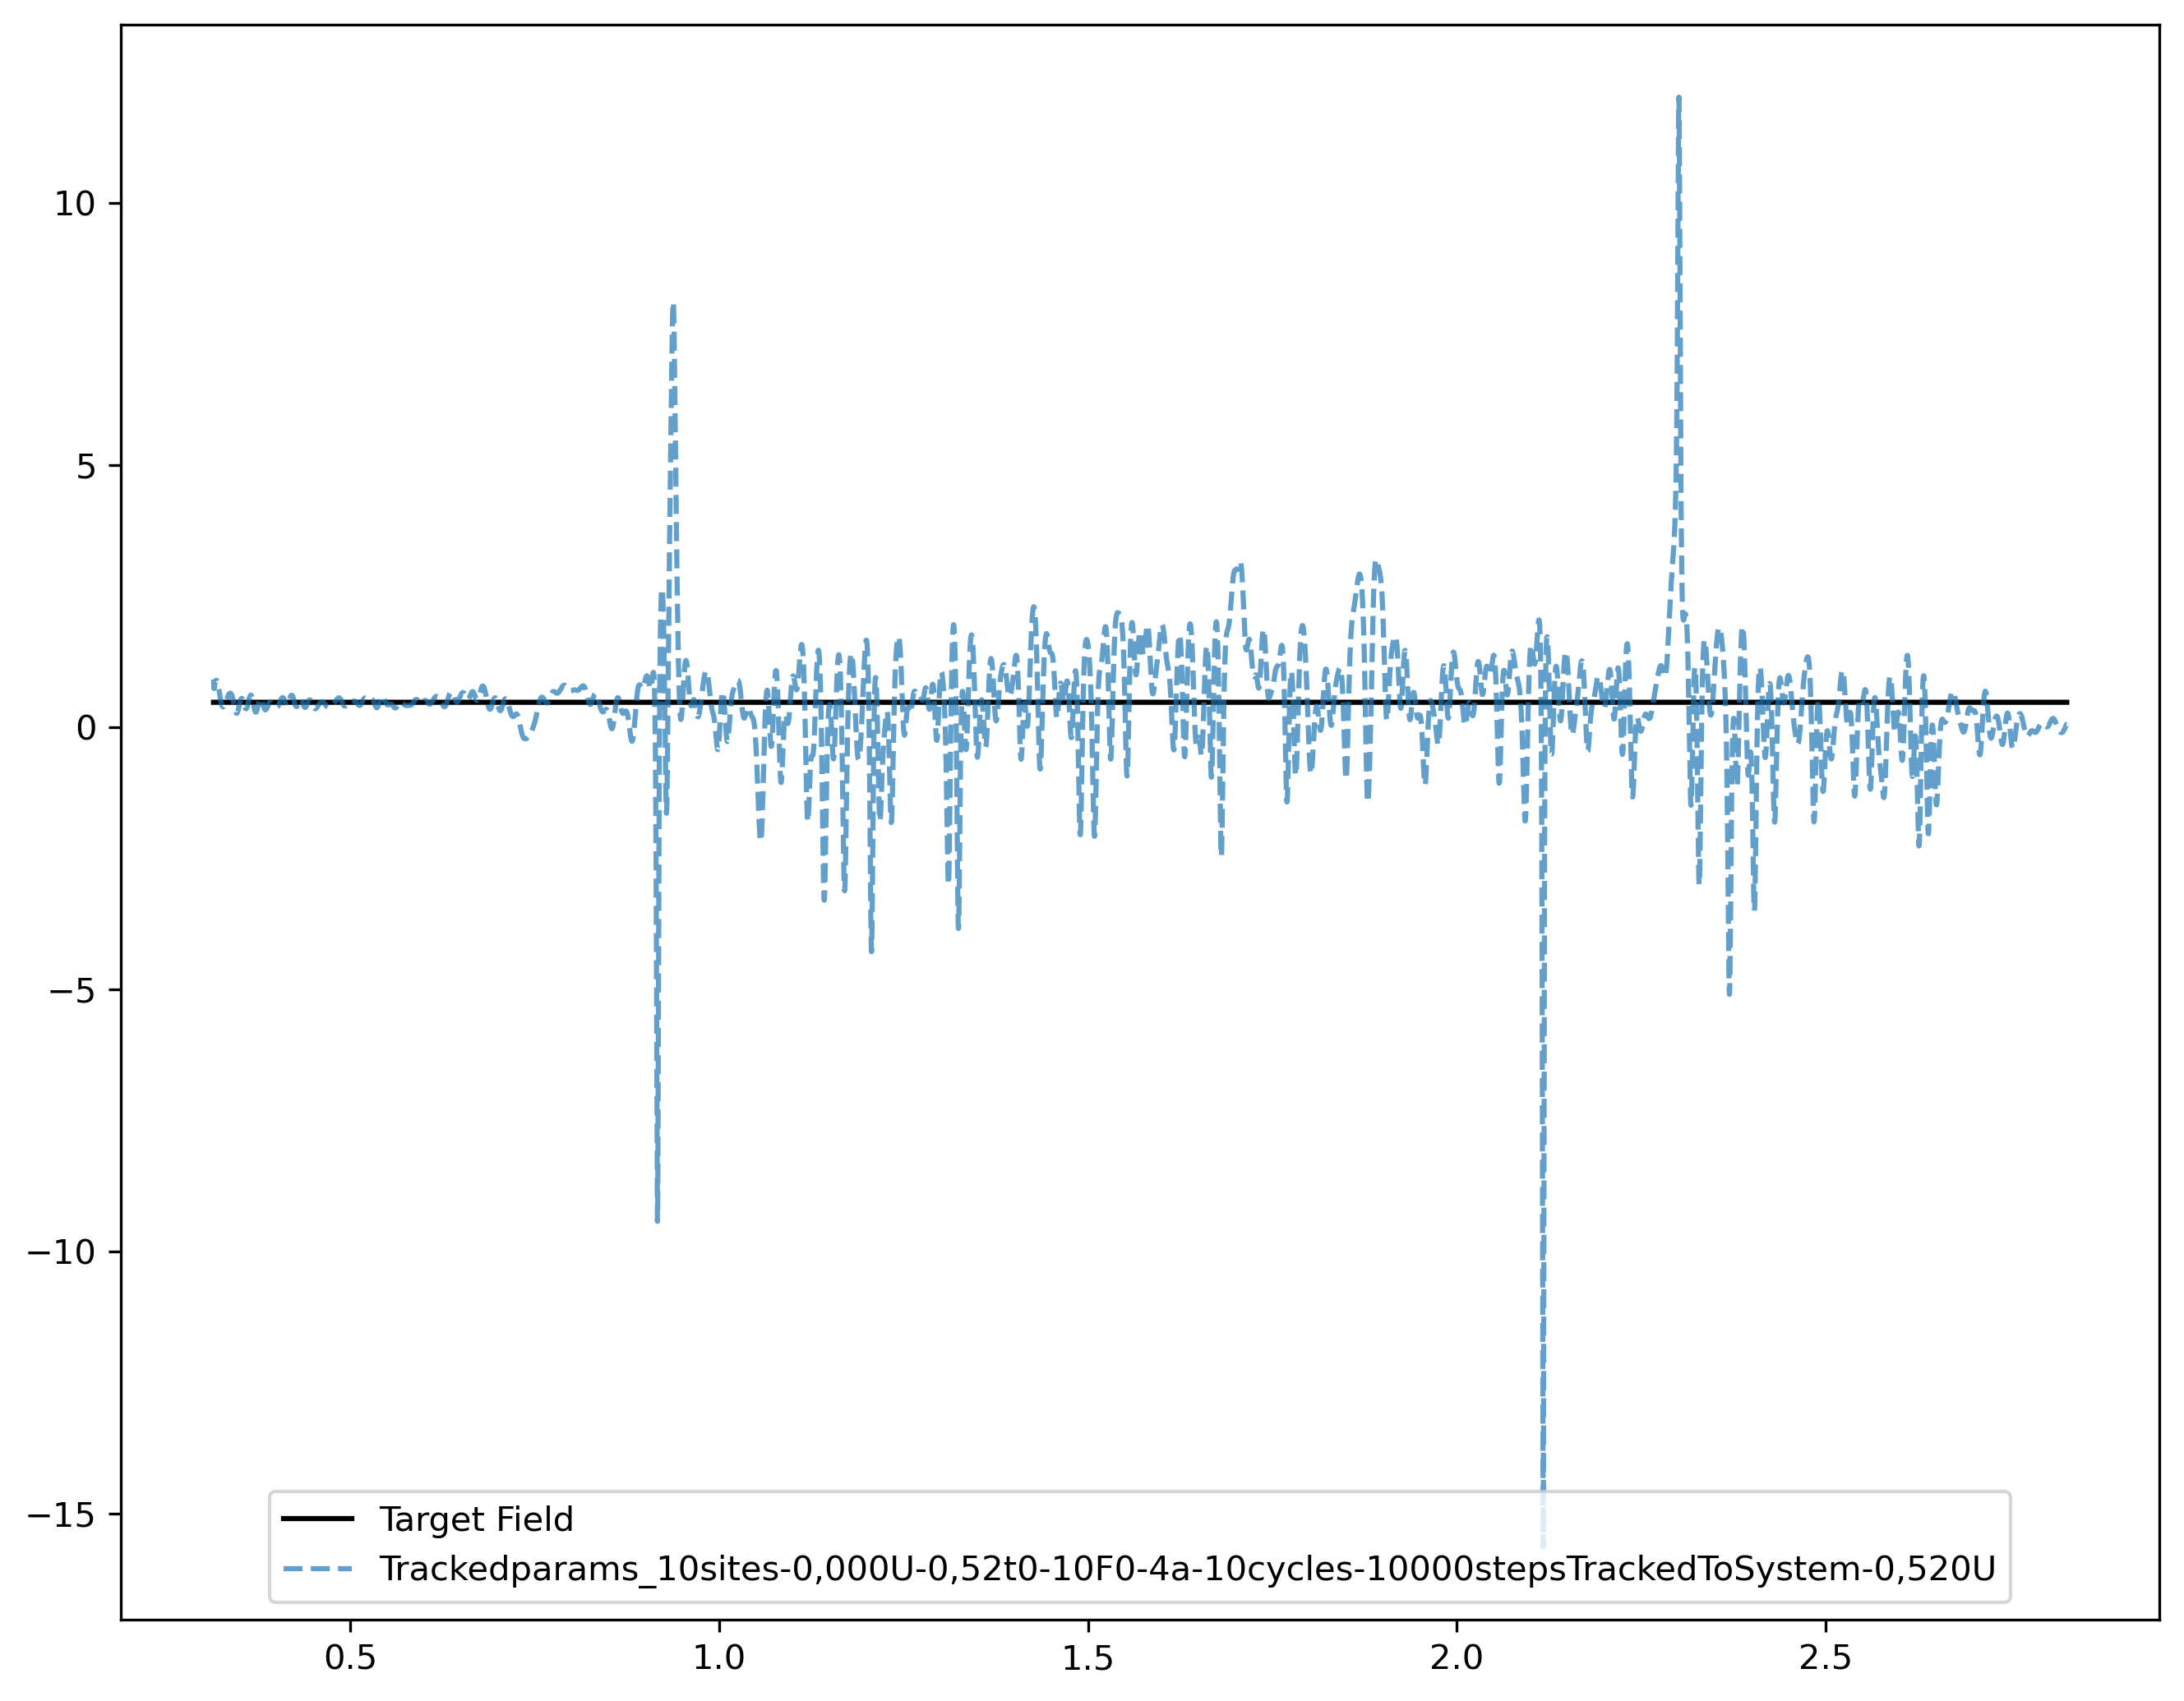

In [12]:
def get_local_freq(pulse):
    phase = np.unwrap(np.angle(hilbert(pulse)), discont=np.pi/2)
    return np.gradient(phase, np.pi / (load.stop - start))

plt.figure(figsize=(9, 7), dpi=300)
keys = list(results_lib)
cut=1000
plt.plot(pi_times[cut:-cut], get_local_freq(tgt_phi(times))[cut:-cut], color='k', label='Target Field')
for _ in keys:
    i=str(_)
    plt.plot(pi_times[cut:-cut], get_local_freq(results_lib[i]['phi'][cut:-cut]), label=i, alpha=0.7, linestyle='--')
    #plt.plot(pi_times[cut:-cut], results_lib[i]['phi'][cut:-cut])
    plt.legend(loc='lower center')
    plt.tight_layout()
    plt.show()

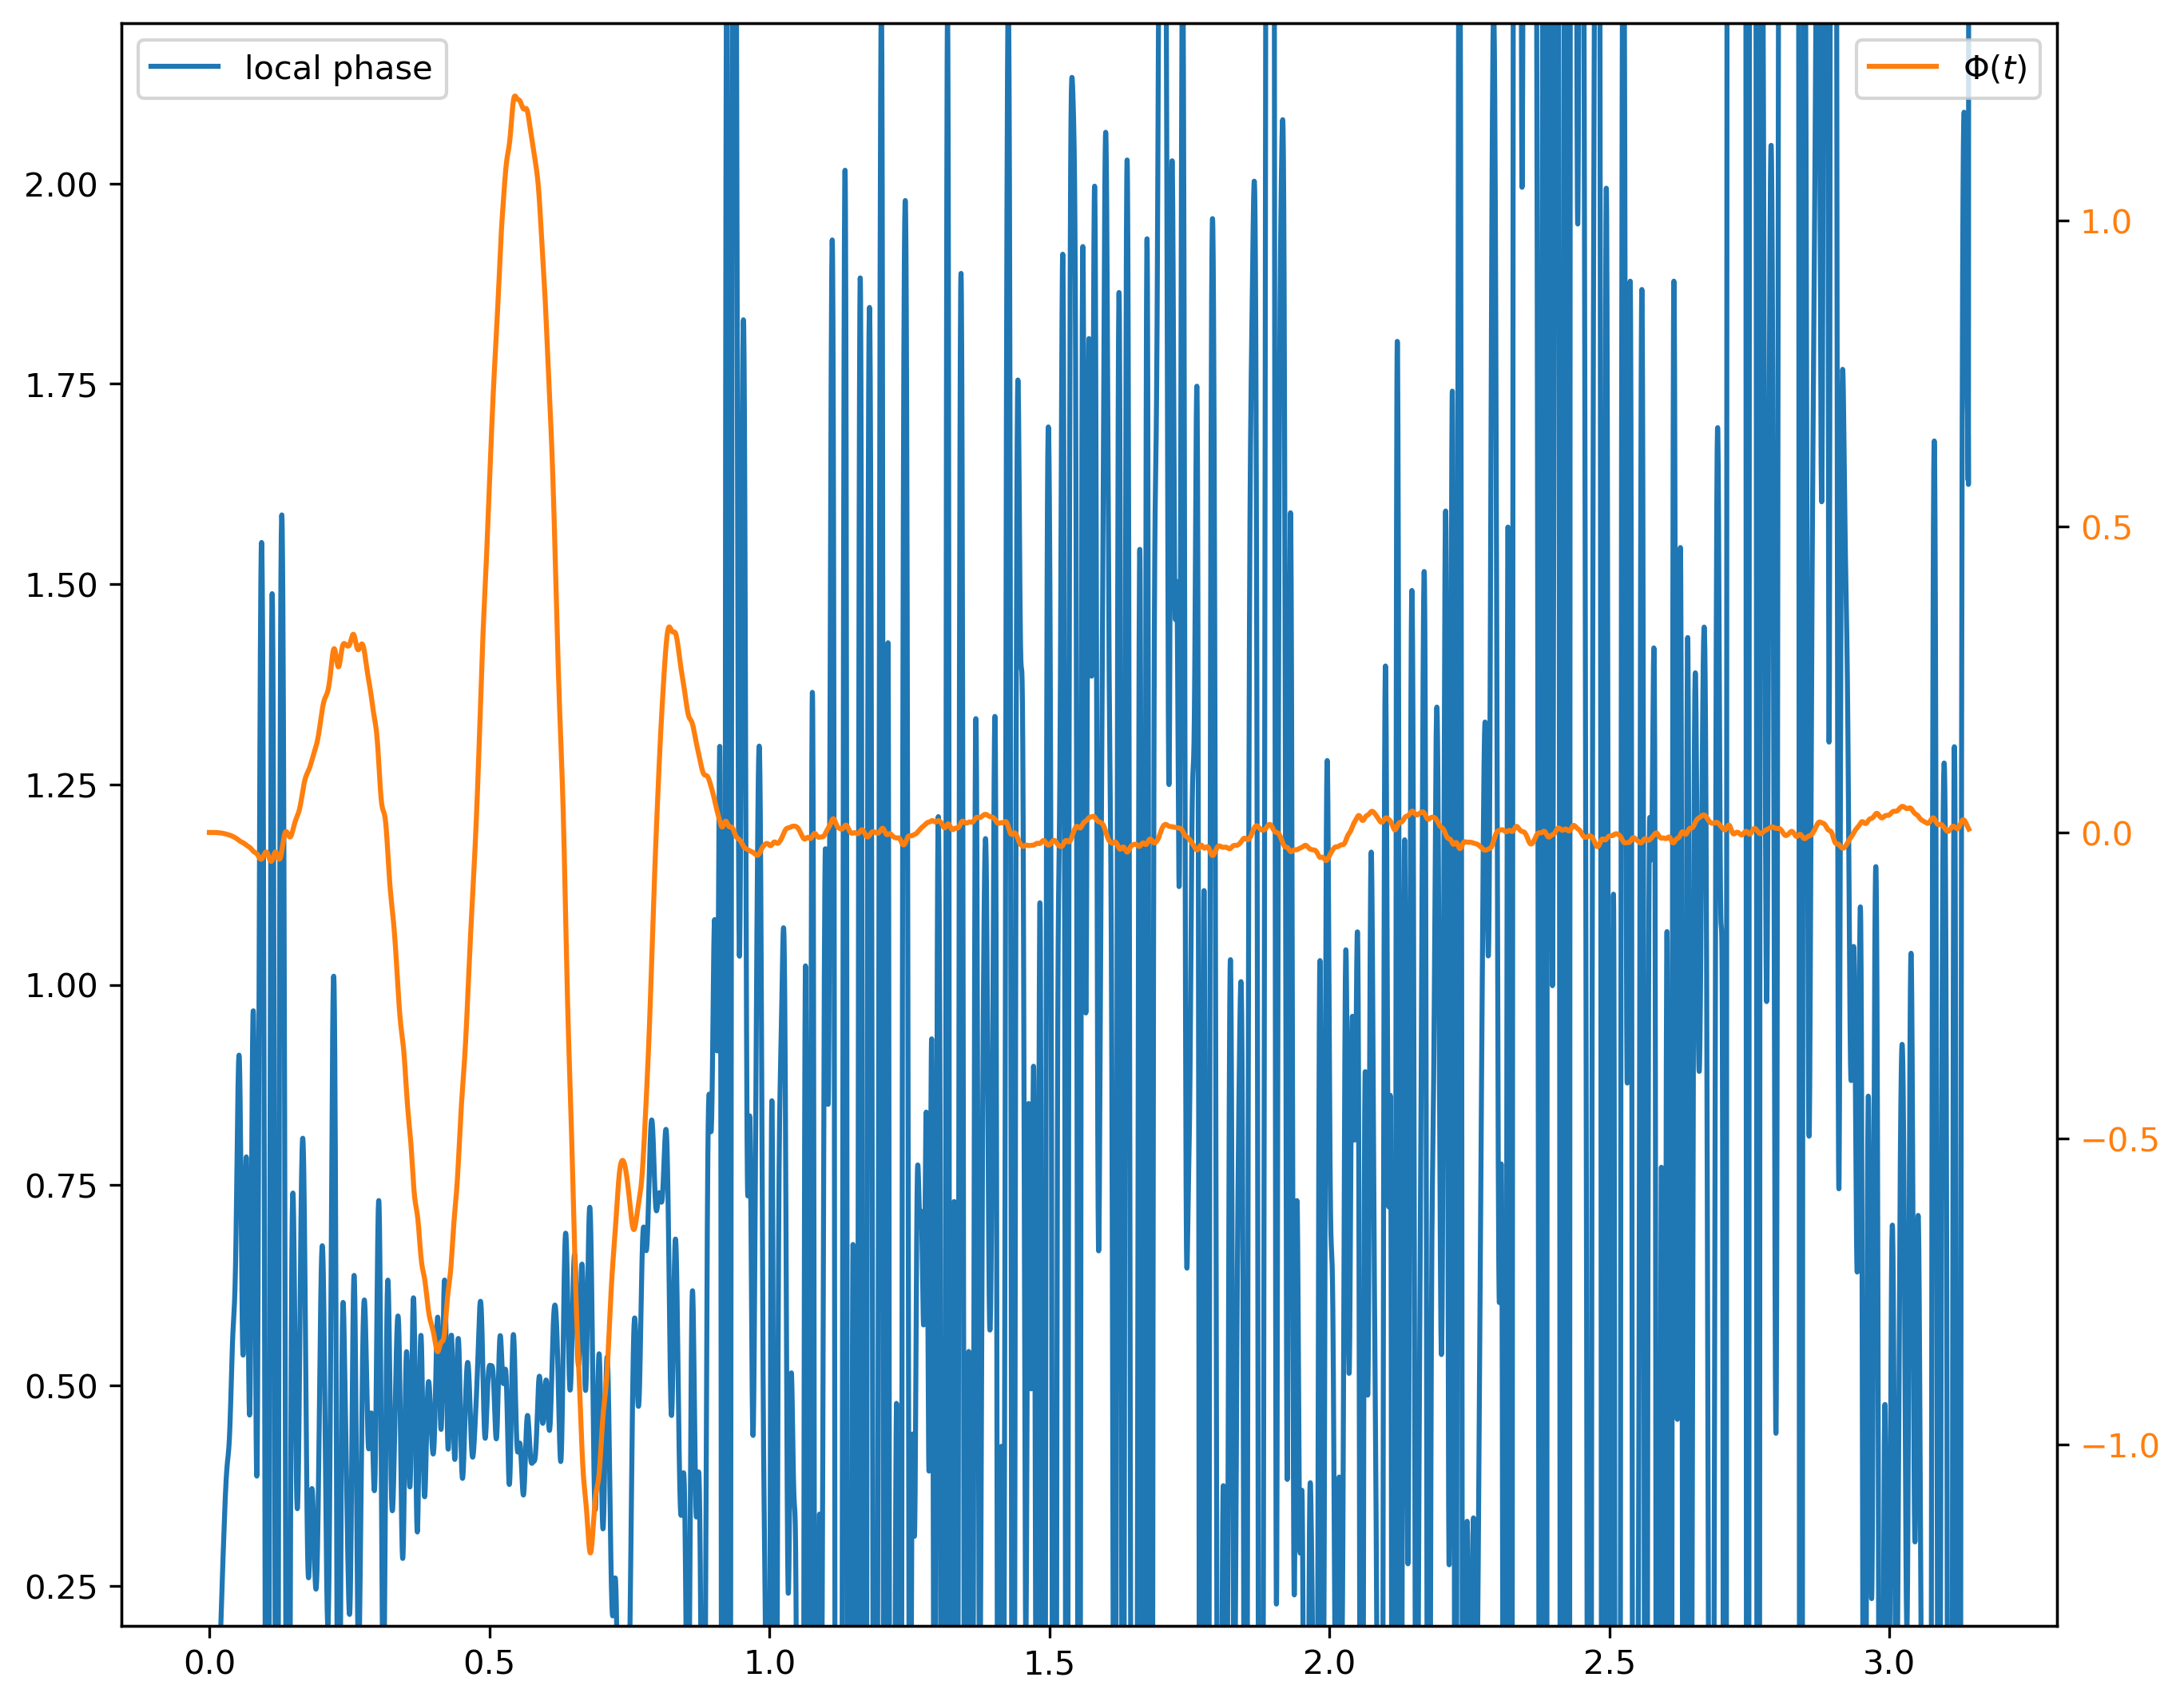

In [13]:
for _ in keys:
    i = str(_)
    
    fig, ax = plt.subplots(constrained_layout=True, figsize=(9, 7), dpi=300)
    ax.plot(pi_times, get_local_freq(results_lib[i]['current'].real), label='local phase')
    ax.set_ylim([0.2, 2.2])
    ax.legend()

    
    ax = ax.twinx()
    
    color = 'tab:orange'
    
    ax.plot(pi_times, results_lib[i]['current'].real, label=r'$\Phi(t)$', color=color)
    ax.tick_params(axis='y', labelcolor=color)
    ax.legend()
    
    
    plt.show()

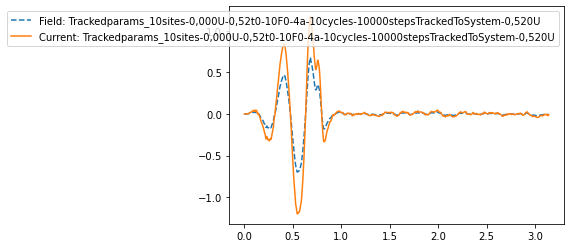

In [18]:
for _ in keys:
    i=str(_)
    plt.plot(pi_times, results_lib[i]['phi'], label='Field: {}'.format(i), linestyle='--')
    plt.plot(pi_times, -1*results_lib[i]['current'].real, label='Current: {}'.format(i))
plt.legend()
plt.show()

In [ ]:
def plot_spectrum(f, t, sim, **kwargs):
    """
    Plot the High Harmonic Generation spectrum
    """
    # Power spectrum emitted is calculated using the Larmor formula
    #   (https://en.wikipedia.org/wiki/Larmor_formula)
    # which says that the power emitted is proportional to the square of the acceleration
    # i.e., the RHS of the second Ehrenfest theorem

    N = len(f)
    k = np.arange(N)

    # frequency range
    omegas = (k - N / 2) * np.pi / (0.5 * t.max())

    # spectra of the
    spectrum = np.abs(
        # used windows fourier transform to calculate the spectra
        # rhttp://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html
        fftpack.fft((-1) ** k * blackman(N) * f)
    ) ** 2
    spectrum /= spectrum.max()
    plt.semilogy(omegas / sim.omega, spectrum, **kwargs, label=get)
    plt.ylabel('spectrum (arbitrary units)')
    plt.xlabel(r'frequency / $\omega$')
    plt.xlim([0, 20])
    plt.ylim([1e-15, 1.])

plt.figure(figsize=(9,9), dpi=300)
for _ in params:
    get = load_tag + params[_].tag
    plot_spectrum(results_lib[get]['phi'], times, params[_])
get = tgt_tag + tgt.tag
plot_spectrum(tgt_phi(times), times, tgt)
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
"""Laser Pulse parameters"""
field = 32.9  # field angular frequency THz
F0 = 4.5      # Field amplitude MV/cm
a = 4         # Lattice constant Angstroms

"""Parameters for a target or reference field"""
# Hubbard model
L = 10             # system size
N_up = L // 2 + L % 2   # number of fermions with spin up
N_down = L // 2     # number of fermions with spin down
N = N_up + N_down   # number of particles
t0 = 0.52       # hopping strength
U = 0.1 * t0    # interaction strength
pbc = True

# Parameters for evolving the system
cycles = 10     # time in cycles of field frequency
n_steps = 4000  # Number of steps for time resolution

# Bundle parameters to pass to Hubbard Model class for unit conversion
tgt_params = dict(
    nx=L,
    hopping=t0,
    interaction=U,
    n_up=N_up,
    n_down=N_down,
    angular_frequency=field,
    lattice_constant=a,
    field_amplitude=F0,
    chem_potential=0,
    cycles=cycles,
    n_steps=n_steps,
    ny=0,       # 1D simulations do not use y-axis
    soc=0,      # No spin orbit coupling
    gamma=0,     #
    tracking=True,  # Are you loading a field for tracking
    int_track=0.1*t0,     # If so, you need to list the U for
    scf=True,
    pulses=25,
    reaping=False
)

# get the converted units for creating a target field
tgt = fhmodel(**tgt_params)
start = 0.0
stop = tgt.stop
times, dt = np.linspace(start, stop, num=n_steps, endpoint=True, retstep=True)
# Reference: 0 for Targets, 1 for Tracking, 2 for superoscillations, 3 for importing anything else
sim_type_to_be_loaded = 3
# Target the filed to be loaded
loader = InitializeArchive(directory_number=sim_type_to_be_loaded).get_dir()
load_path = loader['data path']
load_tag = loader['tag']

# If pasting a direct location, use this
#loadfile = './Data/BestFit_SCF/SCFparams_10sites-0,052TrackedTo0,000U-0,52t0-4,5F0-4TrackedTo4a-10cycles-4000steps-25pulses.npz'
# Otherwise have the class file find it for you
loadfile = load_path + load_tag + tgt.tag + '.npz'
loaded = np.load(loadfile)
print('Loaded file: {}'.format(loadfile))

loaded_field = loaded['phi']
loaded_current = np.real(loaded['current'])
phi = UnivariateSpline(times, loaded_field, k=3, s=0)
current = UnivariateSpline(times, loaded_current, k=3, s=0)


Angular frequency= 0.262
Frequency= 0.042
Lattice constant= 0.144
Field Amplitude= 2.396
Loaded file: ./Data/ImportedFieldResults/ImportFieldparams_10sites-0,052TrackedTo0,052U-0,52t0-4,5F0-4TrackedTo4a-10cycles-4000steps-25pulses.npz


In [25]:
sim_type_to_compare=0
comp = fhmodel(
        nx=L,                       # L for system you want to compare to (should be the same)
        hopping=t0,                 # t0 of system you want to compare to (should be the same)
        interaction=0*t0,            # U of system you want to compare to
        n_up=N_up,                  # (should be the same)
        n_down=N_down,              # (should be the same)
        angular_frequency=field,    # (should be the same)
        lattice_constant=a,         # a of system you want to compare to
        field_amplitude=F0,         # (should be the same)
        chem_potential=0,           # (should be the same)
        cycles=cycles,              # (should be the same)
        n_steps=10000,            # number of steps for system you want to compare to
        ny=0,                       # 1D simulations do not use y-axis
        soc=0,                      # No spin orbit coupling
        gamma=0,                    # No gamma
        tracking=False,             # Are you comparing to a field for tracking
        int_track=0                 # If so, you need to list the U for the system you are tracking to
    )
comp_lib = InitializeArchive(directory_number=sim_type_to_compare).get_dir()
comp_path = comp_lib['data path']
comp_tag = comp_lib['tag'] + comp.tag
comp_file = np.load(comp_path + comp_tag + '.npz')
comp_phi = UnivariateSpline(comp_file['times'], comp_file['phi'], k=3, s=0)
comp_J = UnivariateSpline(comp_file['times'], comp_file['current'], k=3, s=0)

Angular frequency= 0.262
Frequency= 0.042
Lattice constant= 0.144
Field Amplitude= 2.396


In [26]:
sim_type_to_compare=0
comp2 = fhmodel(
        nx=L,                       # L for system you want to compare to (should be the same)
        hopping=t0,                 # t0 of system you want to compare to (should be the same)
        interaction=0.1*t0,            # U of system you want to compare to
        n_up=N_up,                  # (should be the same)
        n_down=N_down,              # (should be the same)
        angular_frequency=field,    # (should be the same)
        lattice_constant=a,         # a of system you want to compare to
        field_amplitude=F0,         # (should be the same)
        chem_potential=0,           # (should be the same)
        cycles=cycles,              # (should be the same)
        n_steps=10000,            # number of steps for system you want to compare to
        ny=0,                       # 1D simulations do not use y-axis
        soc=0,                      # No spin orbit coupling
        gamma=0,                    # No gamma
        tracking=False,             # Are you comparing to a field for tracking
        int_track=0                 # If so, you need to list the U for the system you are tracking to
    )
comp_lib2 = InitializeArchive(directory_number=sim_type_to_compare).get_dir()
comp_path2 = comp_lib2['data path']
comp_tag2 = comp_lib2['tag'] + comp2.tag
comp_file2 = np.load(comp_path2 + comp_tag2 + '.npz')
comp_phi2 = UnivariateSpline(comp_file2['times'], comp_file2['phi'], k=3, s=0)
comp_J2 = UnivariateSpline(comp_file2['times'], comp_file2['current'], k=3, s=0)

Angular frequency= 0.262
Frequency= 0.042
Lattice constant= 0.144
Field Amplitude= 2.396


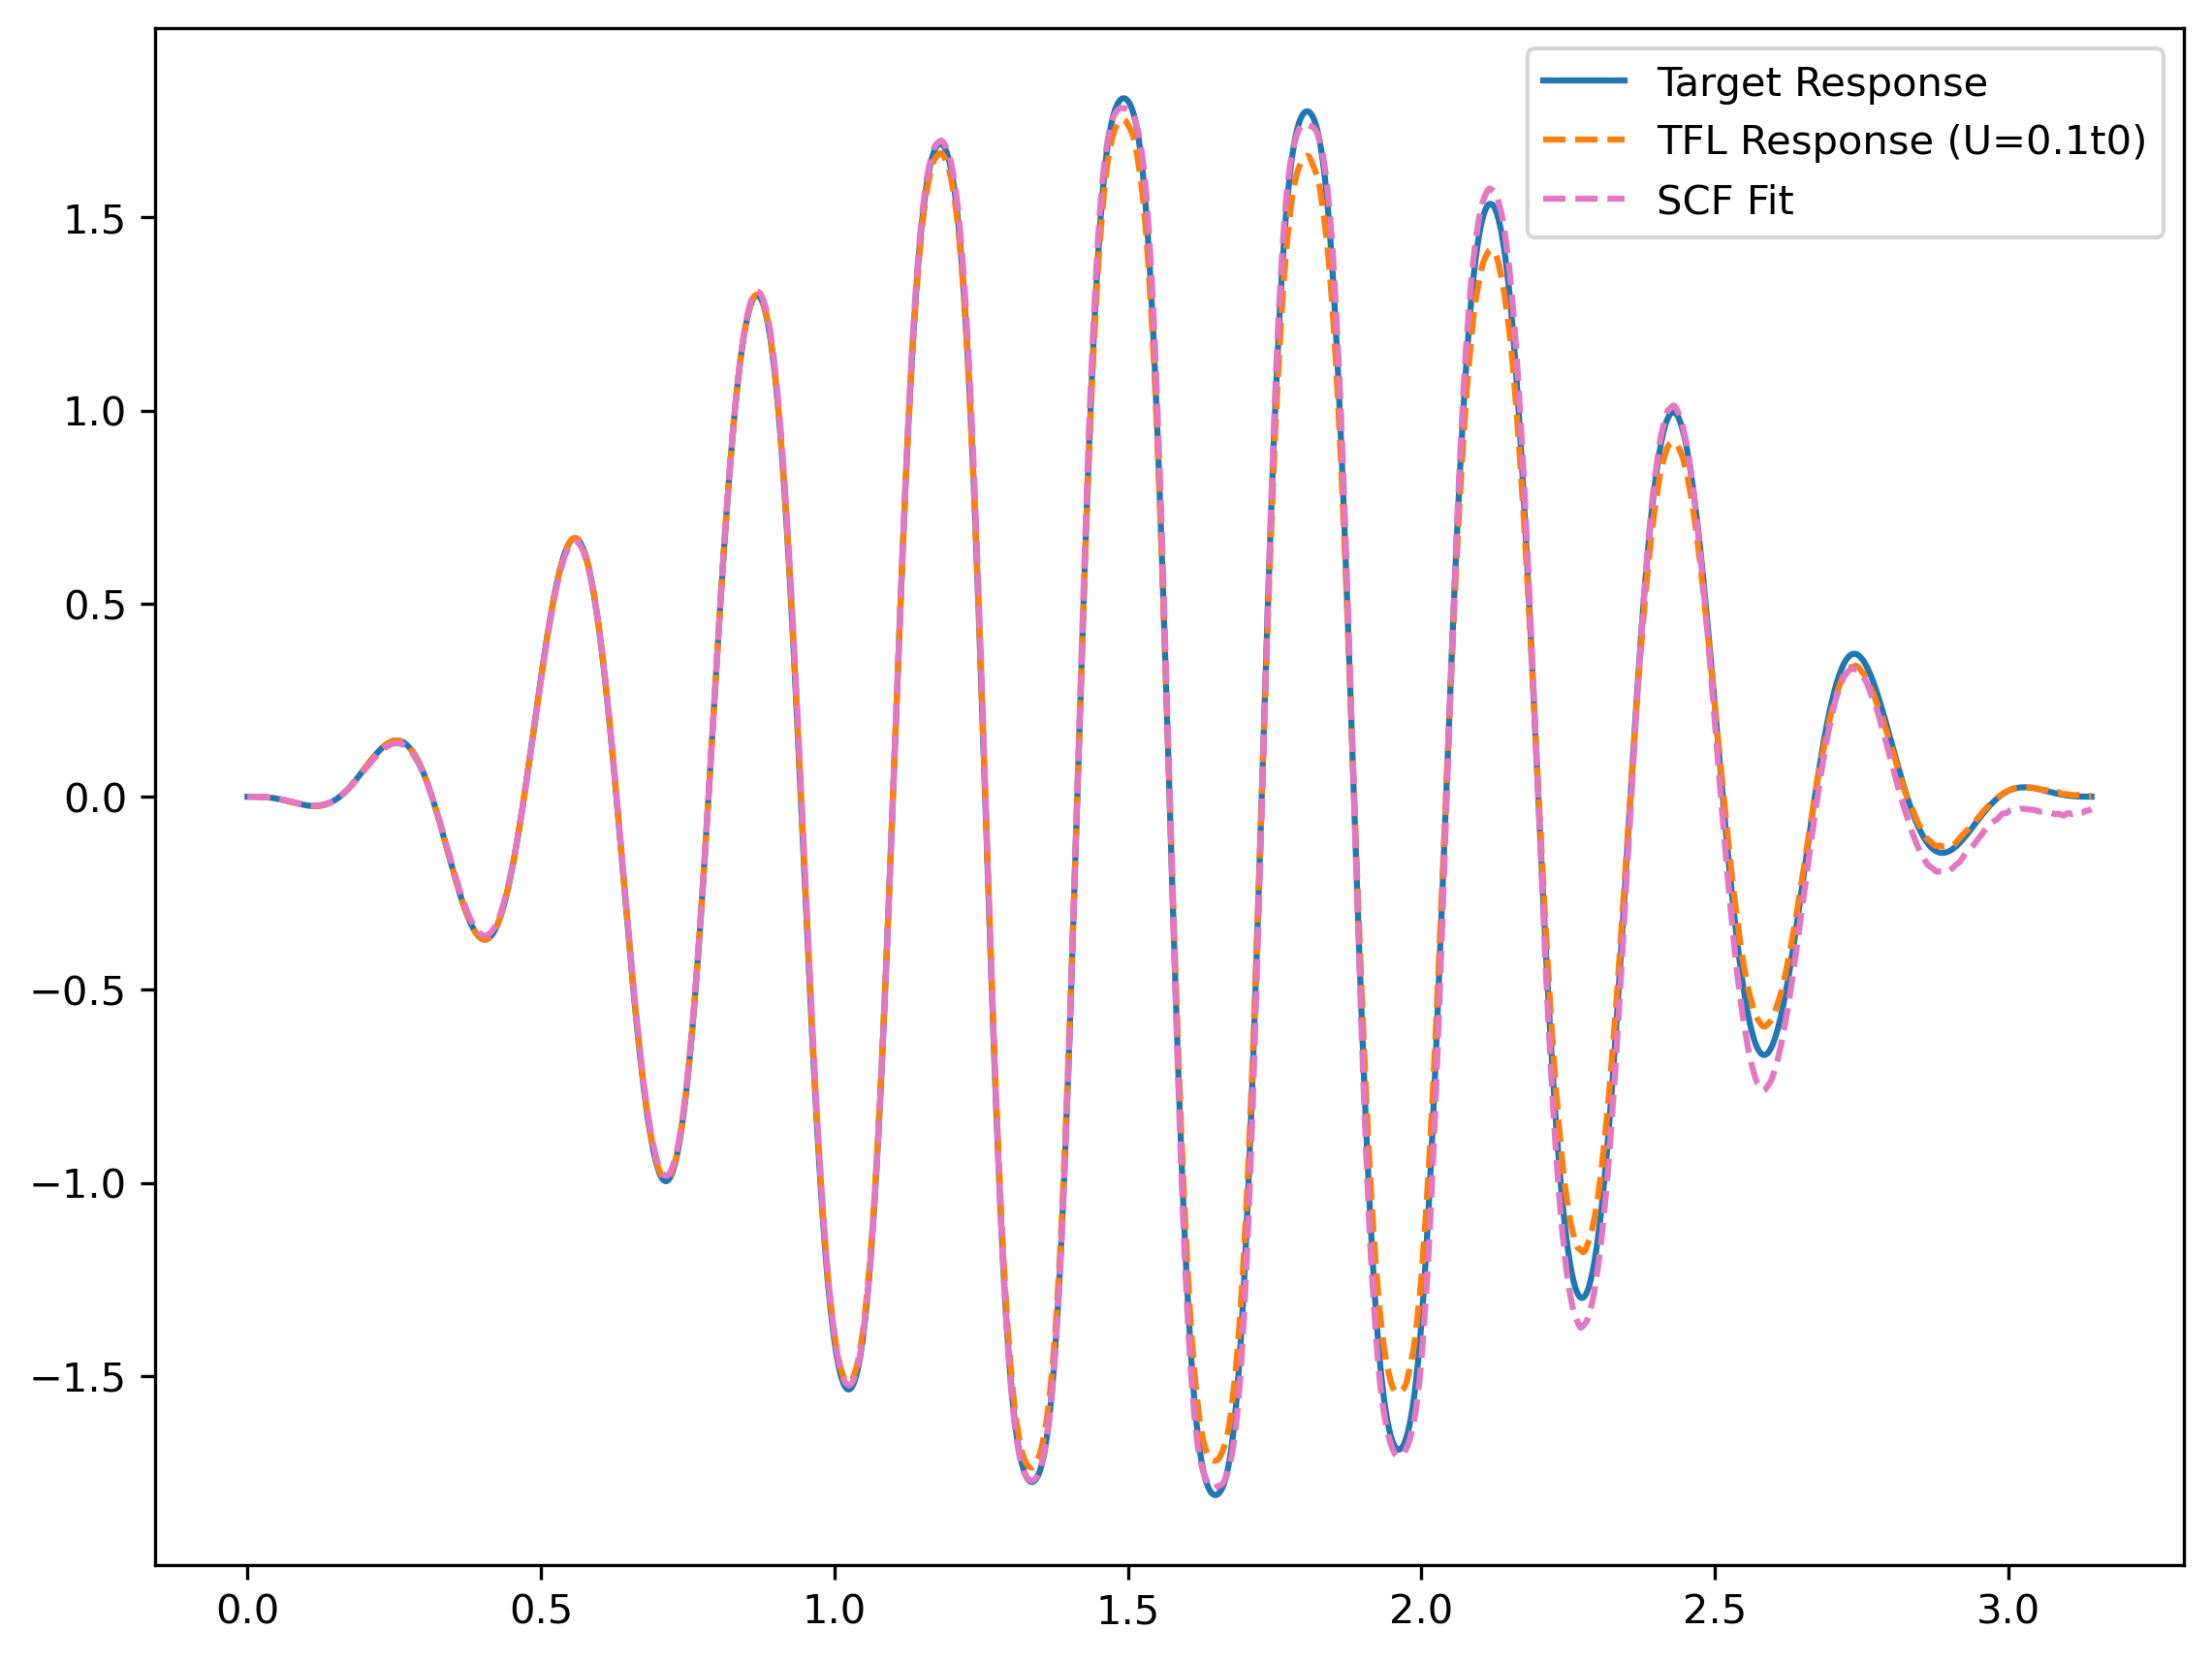

In [36]:
plt.figure(figsize=(9,7), dpi=300)
plt.plot(pi_times, comp_J(times), label='Target Response')
plt.plot(pi_times, comp_J2(times), label='TFL Response (U=0.1t0)', linestyle='--')
plt.plot(pi_times, current(times), label='SCF Fit', color='tab:pink', linestyle='--')
plt.legend()

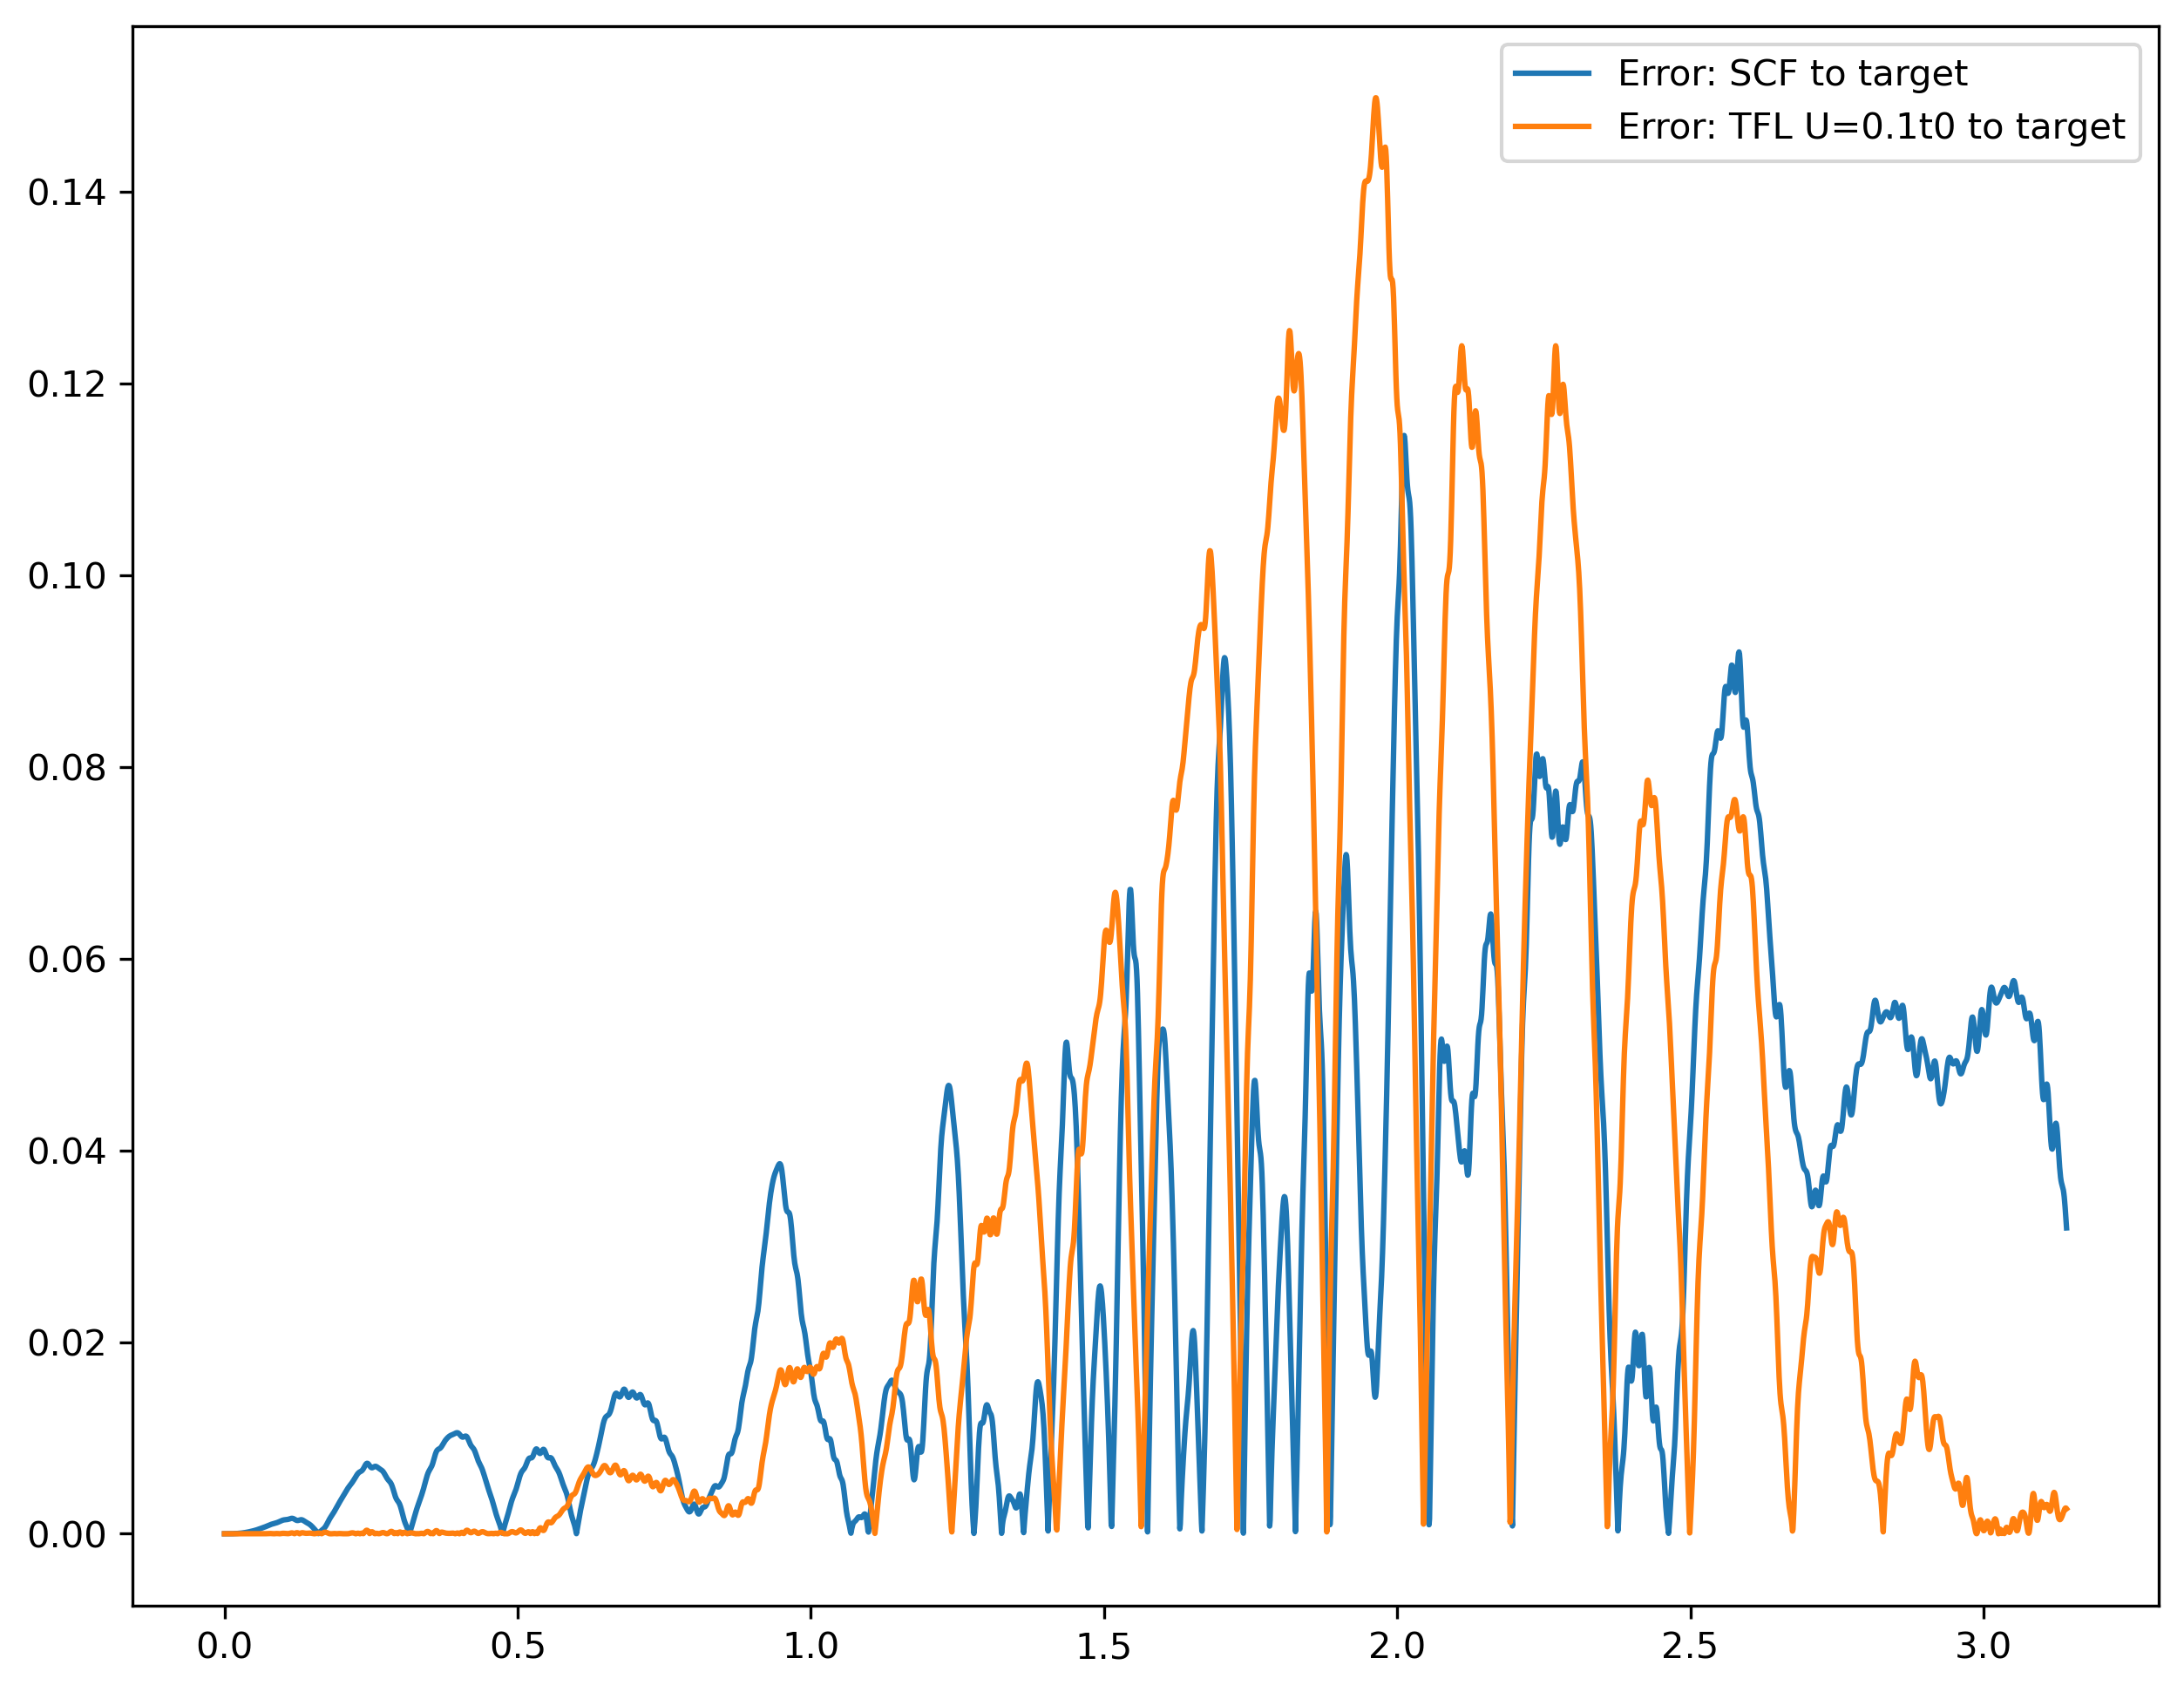

Quantified difference of SCF: 0.36972502645682737
Quantified difference of TFL: 0.6290601337436967


In [38]:
diff1=np.abs(comp_J(times) - current(times))
diff2=np.abs(comp_J(times) - comp_J2(times))

qdiff1=np.linalg.norm(comp_J(times) - current(times)) ** 2 * dt
qdiff2=np.linalg.norm(comp_J(times) - comp_J2(times)) ** 2 * dt

plt.figure(figsize=(10,8), dpi=300)
plt.plot(pi_times, diff1, label='Error: SCF to target')
plt.plot(pi_times, diff2, label='Error: TFL U=0.1t0 to target')
plt.legend()
plt.show()

print('Quantified difference of SCF: {}'.format(qdiff1))

print('Quantified difference of TFL: {}'.format(qdiff2))